# Testing classifiers

The question here is: How can we decide if a classifier is doing a good job?

## The Tekno Corpus

We'll use the Tekno corpus as a testbed

## Read in the data

In [ ]:
import csv
csvfile = open('corpora/tekno_flat.csv')
tekno_reader = csv.DictReader(csvfile)
data_list = []
for row in tekno_reader:
    data_list.append(row)

In [ ]:
datum = data_list[0]

In [ ]:
datum["TEXT"]

In [ ]:
print(datum["CODEMC"])
print(datum["CODEST"])
print(datum["CODESII"])
print(datum["CODELI"])

In [ ]:
print(datum["CLIP"])

## Tokenize, etc.

In [ ]:
def bruces_twitter_tokenizer(text):
    import re
    
    def is_contraction(the_text):
        contraction_patterns = re.compile(r"(?i)(.)('ll|'re|'ve|n't|'s|'m|'d)\b")
        return contraction_patterns.search(the_text)
    
    punctuation_class = r"([\.\-\/&\";:\(\)\?\!\]\[\{\}\*#])"
    
    # eliminate_urls
    text = re.sub(r"http\S*", "", text)
    
    # elimintate hashtags, user mentionds
    text = re.sub(r"#\S*", "", text)
    text = re.sub(r"@\S*", "", text)
    
    # Separate most punctuation at end of words

    text = re.sub(r"(\w)" + punctuation_class, r'\1 \2 ', text)
    
    # Separate most punctuation at start of words
    text = re.sub(punctuation_class + r"(\w)", r'\1 \2', text)
    
    # Separate punctuation from other punctuation
    text = re.sub(punctuation_class + punctuation_class, r'\1 \2 ', text)
    
    # Put spaces between + and = signs and digits. Also %s that follow a digit, $s that come before a digit
    text = re.sub(r"(\d)([+=%])", r'\1 \2 ', text)
    text = re.sub(r"([\$+=])(\d)", r'\1 \2', text)
    
    # Separate commas if they're followed by space.
    # (E.g., don't separate 2,500)
    text = re.sub(r"(,\s)", r' \1', text)
    
    #when we have two double quotes make it 1.
    #
    text = re.sub("\"\"", "\"", text)

    # Separate leading and trailing single and double quotes .
    text = re.sub(r"(\'\s)", r' \1', text)
    text = re.sub(r"(\s\')", r'\1 ', text)
    text = re.sub(r"(\"\s)", r' \1', text)
    text = re.sub(r"(\s\")", r'\1 ', text)
    text = re.sub(r"(^\")", r'\1 ', text)
    text = re.sub(r"(^\')", r'\1 ', text)
    text = re.sub(r"('\'$)", r' \1', text)
    text = re.sub(r"('\"$)", r' \1', text)

    #Separate parentheses where appropriate
    text = re.sub(r"(\)\s)", r' \1', text)
    text = re.sub(r"(\s\()", r'\1 ', text)

    # Separate periods that come before newline or end of string.
    text = re.sub('\. *(\n|$)', ' . ', text)
    
    # separate single quotes in the middle of words
    # text = re.sub(r"(\w)(\')(\w)", r'\1 \2 \3', text)
    
    # separate out 's at the end of words
    text = re.sub(r"(\w)(\'s)(\s)", r"\1 s ", text)
    split_text = text.split()
    
    return split_text

### preload a list of all clip names and codes

In [ ]:
clip_names = []
for datum in data_list:
    clip_names.append(datum["CLIP"])
clip_names = set(clip_names)
print(clip_names)
allowed_codes = ["0", "1", "2"]

### Set parameters that will govern an analysis

In [ ]:
code = "CODEMC"
vocab_size = 100
stop_list = "lists/stop-words_english_5_en.txt"
test_fraction = .1
clips_to_include = clip_names

### Tokenize

In [ ]:
tokenized_data_list = []
for datum in data_list:
    if datum["CLIP"] in clips_to_include and datum[code] in allowed_codes:
        new_row = [bruces_twitter_tokenizer(datum["TEXT"].lower()), datum[code]]
        tokenized_data_list.append(new_row)

In [ ]:
print(tokenized_data_list[0])

### Build the vocabulary

In [ ]:
f = open(stop_list)
stop_list = f.read().split("\n")
stop_list += list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’')
stop_list += list("abcdefghijklmnopqrstuvwxyz0123456789")
stop_list = set(stop_list)

In [ ]:
import nltk
word_fdist = nltk.FreqDist() # the corpus frequences
for row in tokenized_data_list:
    for word in row[0]:
        if not word in stop_list:
            word_fdist[word] += 1

In [ ]:
mc = word_fdist.most_common(vocab_size)
vocab = [w[0] for w in mc]
print(vocab)

### Create labeled featuresets

In [ ]:
def word_feature_extractor(the_text, vocab):
    features = {}
    for word in vocab:
        features['contains(%s)' % word] = (word in the_text)
    return features

def word_feature_extractor_with_length(the_text, vocab):
    features = {}
    for word in vocab:
        features['contains(%s)' % word] = (word in the_text)
    if len(the_text) > 25:
        features["long"] = True
    else:
        features["long"] = False
    return features

fe = word_feature_extractor

In [ ]:
labeled_featuresets = []
for row in tokenized_data_list:
    new_lf = [fe(row[0], vocab), row[1]]
    labeled_featuresets.append(new_lf)

## Shuffle and train and test

In [ ]:
import random
random.shuffle(labeled_featuresets)
nfeatures = len(labeled_featuresets)
test_fraction = .1

test_size = round(test_fraction * nfeatures)
test_set = labeled_featuresets[:test_size]
train_set = labeled_featuresets[test_size:]

In [ ]:
tekno_classifier = nltk.NaiveBayesClassifier.train(train_set)

In [ ]:
print("accuracy is {}".format(nltk.classify.accuracy(tekno_classifier, test_set)))
gold_list = [t[1] for t in test_set]
test_list = [tekno_classifier.classify(t[0]) for t in test_set]
cm = nltk.ConfusionMatrix(gold_list, test_list)
print(cm)

In [ ]:
import sklearn
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(gold_list, test_list)

## Testing systematically

### About overfitting and underfitting

We could always train a classifer that does perfectly on the training set. In that case, however, the classifier would be attending overly to the idiosyncracies of the training set. 

One way this could happen is if we include too many features in our featuresets.

So we want to train in such a way that we pay just the right amount of attention to features in the training set - not too much and not too little.

### Cross-validation

Image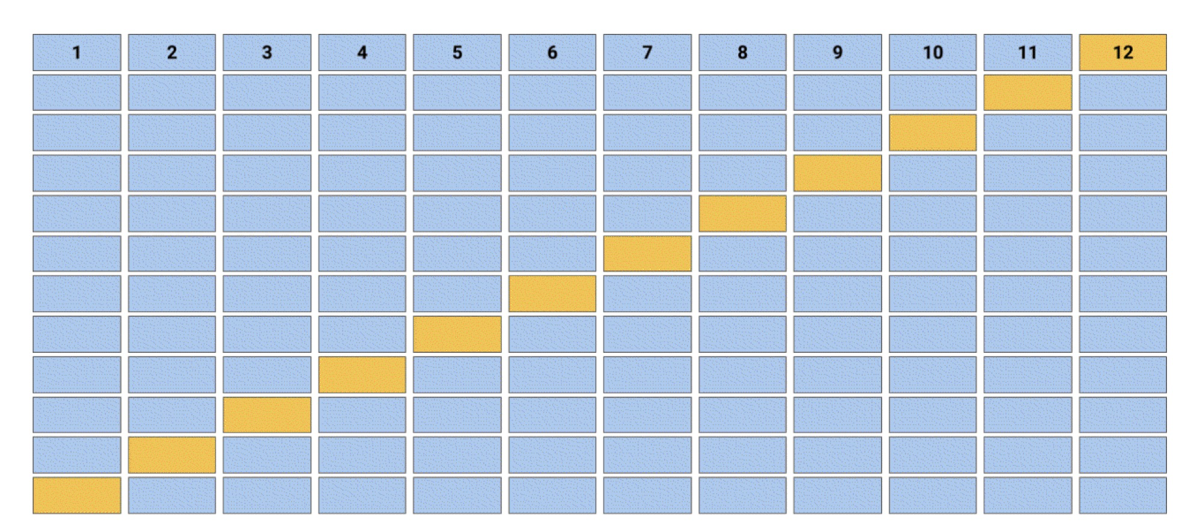

## Create all of the functions we'll need

Mostly, I'm bottling up everything we did above. 

But I'm also adding a wrapper that does the cross-validation.

In [ ]:
import sklearn
from sklearn.metrics import cohen_kappa_score
import random

code = "CODEMC"
clips_to_include = clip_names
vocab_size = 100
stop_list = "lists/stop-words_english_5_en.txt"
test_fraction = .1
fe = word_feature_extractor

def prepare_featuresets(clips_to_include, stop_list, vocab_size, code, fe):
    tokenized_data_list = []
    for datum in data_list:
        if datum["CLIP"] in clips_to_include and datum[code] in allowed_codes:
            new_row = [bruces_twitter_tokenizer(datum["TEXT"].lower()), datum[code]]
            tokenized_data_list.append(new_row)
    f = open(stop_list)
    stop_list = f.read().split("\n")
    stop_list += list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’')
    stop_list += list("abcdefghijklmnopqrstuvwxyz0123456789")
    stop_list = set(stop_list)
    import nltk
    word_fdist = nltk.FreqDist() # the corpus frequences
    for row in tokenized_data_list:
        for word in row[0]:
            if not word in stop_list:
                word_fdist[word] += 1
    mc = word_fdist.most_common(vocab_size)
    vocab = [w[0] for w in mc]

    labeled_featuresets = []
    for row in tokenized_data_list:
        new_lf = [fe(row[0], vocab), row[1]]
        labeled_featuresets.append(new_lf)
    return labeled_featuresets

def test_classifier(train_set, test_set):
    tekno_classifier = nltk.NaiveBayesClassifier.train(train_set)
    accuracy = nltk.classify.accuracy(tekno_classifier, test_set)
    gold_list = [t[1] for t in test_set]
    test_list = [tekno_classifier.classify(t[0]) for t in test_set]
    kappa = cohen_kappa_score(gold_list, test_list)
    return {"accuracy": accuracy, "kappa": kappa}

def cross_validate(test_fraction, labeled_featuresets):
    nchunks = round(1 / test_fraction)
    test_size = round(test_fraction * len(labeled_featuresets))
    chunk_starts = [n * test_size for n in range(nchunks)]
    random.shuffle(labeled_featuresets)
    data_chunks = [labeled_featuresets[start:start+test_size] for start in chunk_starts]
    test_set = None
    train_set = []
    results = []
    for n in range(nchunks):
        for m, c in enumerate(data_chunks):
            if m == n:
                test_set = c
            else:
                train_set += c
        res = test_classifier(train_set, test_set)
        print(res)
        results.append(res)
    average_accuracy = sum([res["accuracy"] for res in results]) / len(results)
    average_kappa = sum([res["kappa"] for res in results]) / len(results)
    print("average accuracy: {}, average kappa: {}".format(round(average_accuracy, 3), round(average_kappa, 3)))
    
    return results, average_accuracy, average_kappa

def run_full_test(code_to_test, clips, vsize, slist, tfraction, feature_extractor):
    lfs = prepare_featuresets(clips, slist, vsize, code_to_test, feature_extractor)
    return cross_validate(tfraction, lfs)

## Do some tests

In [ ]:
results, acc, kappa = run_full_test("CODEMC", 
                                    clip_names, 
                                    100, 
                                    "lists/stop-words_english_5_en.txt", 
                                    .1, 
                                    word_feature_extractor)

In [ ]:
results, acc, kappa = run_full_test("CODEMC", 
                                    clip_names, 
                                    100, 
                                    "lists/stop-words_english_5_en.txt", 
                                    .1, 
                                    word_feature_extractor)

In [ ]:
results, acc, kappa = run_full_test("CODEMC", 
                                    clip_names, 
                                    10, 
                                    "lists/stop-words_english_5_en.txt", 
                                    .1, 
                                    word_feature_extractor)

In [ ]:
results, acc, kappa = run_full_test("CODEMC", 
                                    clip_names, 
                                    10, 
                                    "lists/stop-words_english_5_en.txt", 
                                    .1, 
                                    word_feature_extractor)

In [ ]:
results, acc, kappa = run_full_test("CODEMC", 
                                    clip_names, 
                                    200, 
                                    "lists/stop-words_english_5_en.txt", 
                                    .1, 
                                    word_feature_extractor)

In [ ]:
results, acc, kappa = run_full_test("CODEMC", 
                                    ["2"], 
                                    200, 
                                    "lists/stop-words_english_5_en.txt", 
                                    .1, 
                                    word_feature_extractor)